# Linear Modeling - Multiple

We previously considered a single covariate in the linear model and saw how the linear equation could be used to find the coefficients that fit the model by minimizing the sum of squares

![lm_multi.png](images/lm_multi.png)

The linear model can be extended to accomodate additional covariates as independent variables (i.e. they do not depend on each other)

We will explore 
- how multiple covariates can be fitted using the linear model
- what the addition of covariates means
- what problems may arise from selection of covariates

---
## Data preparation

We will use the dataset from the Framingham study, which was a long term study of cardiovascular disease about subjsects in Framingham, USA. In this dataset ~4000 subjects were followed up and clinical data and chronic heart disease outcomes were examined longitudinally over > 10 years

Variables include:
- `male` : 0 = female, 1 = male
- `age` : Age at the time of medical examination in years.
- `education` : 1 = Some high school, 2 = high school/GED, 3 = some college/vocational school, 4 = college
- `currentSmoker`: Current cigarette smoking at the time of examinations
- `cigsPerDay`: Number of cigarettes smoked each day
- `BPmeds`: Use of Anti-hypertensive medication at exam
- `prevalentStroke`: Prevalent Stroke 
- `prevalentHyp`: Prevalent Hypertensive
- `diabetes`: Diabetic according to criteria of first exam treated
- `totChol`: Total cholesterol (mg/dL)
- `sysBP`: Systolic Blood Pressure (mmHg)
- `diaBP`: Diastolic blood pressure (mmHg)
- `BMI`: Body Mass Index, weight (kg)/height (m)^2
- `heartRate`: Heart rate (beats/minute)
- `glucose`: Blood glucose level (mg/dL)

We will build a model with `sysBP` as a response and explore its relationship with other variable(s). In this case, we will filter out cases that are on antihypertensive medication `BPMeds == 0`

In [1]:
library(tidyverse)

# load data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# filter out cases with BPMeds and drop missing values
data <- data %>%
        filter(BPMeds==0) %>%
        drop_na  

head(data)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Rows: 4240 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (16): male, age, education, currentSmoker, cigsPerDay, BPMeds, prevalent...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,39,4,0,0,0,0,0,0,195,106.0,70,26.97,80,77,0
0,46,2,0,0,0,0,0,0,250,121.0,81,28.73,95,76,0
1,48,1,1,20,0,0,0,0,245,127.5,80,25.34,75,70,0
0,61,3,1,30,0,0,1,0,225,150.0,95,28.58,65,103,1
0,46,3,1,23,0,0,0,0,285,130.0,84,23.10,85,85,0
0,43,2,0,0,0,0,1,0,228,180.0,110,30.30,77,99,0


We can use the `ggpairs` from the `GGally` library to do the pairwise plots and see the relationships between different variables
- `sysBP`
- `BMI`
- `age`

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



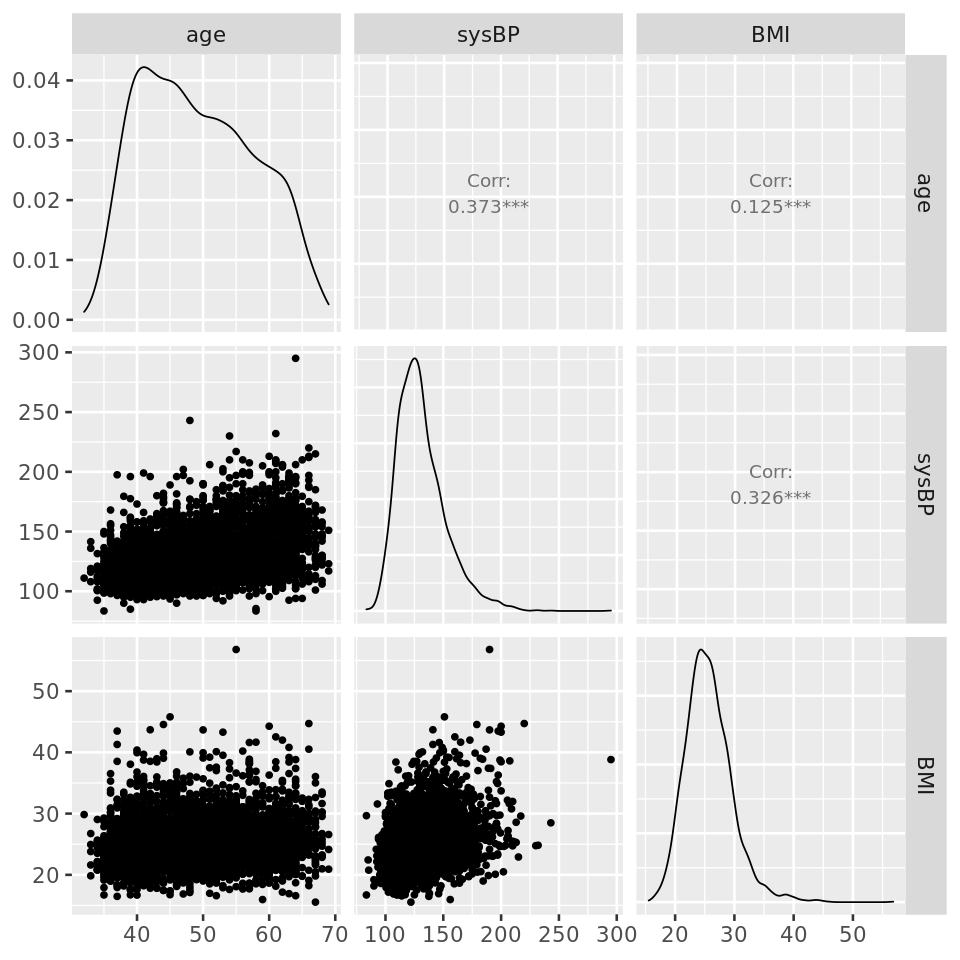

In [2]:
library(GGally)

# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

data %>% select(age, sysBP, BMI) %>% 
         ggpairs() +
         theme_grey(base_size=16)

Recall that in the previous notebook, we estimated the effect of BMI on systolic BP

In [3]:
fit_BMI <- lm(sysBP ~ BMI, data)

fit_BMI %>% broom::tidy() %>% # tidy up the linear model output
            select(term, estimate)

term,estimate
<chr>,<dbl>
(Intercept),87.068295
BMI,1.721042


Let us get the estimates for the effect of age on systolic BP

In [4]:
fit_age <- lm(sysBP ~ age, data)

fit_age %>% broom::tidy() %>% # tidy up the linear model output
            select(term, estimate)

term,estimate
<chr>,<dbl>
(Intercept),85.7252063
age,0.9237601


When performing regression on the individual covariates (age OR BMI) separately, we are not sure about the contributions of **both** age and BMI on the systolic BP
- For example, if there was an association between age and BMI, the effect of BMI on the systolic BP could be overestimated because we did not account for the effect of age on BMI

![lm_bmi_age_bp.png](images/lm_bmi_age_bp.png)

The inclusion of both covariates in the model would allow us to address these questions
- What is the association of BMI on systolic BP when age is kept constant?
- What is the association of age on systolic BP when BMI is kept constant?

We will explore how we can fit **both** covariates in the model

## Solving the linear model using matrices

We can accomodate additional covariates by extending the linear equation

$$y_{i}=\beta_{0}+\beta_{1} x_{i 1}+\beta_{2} x_{i 2}+\ldots+\beta_{k} x_{i k}+e_{i}\quad$$

$$\text{for}\ i =\text{sample},k =\text{independent variable}$$

This can be expressed in a matrix form

$$\left[\begin{array}{l}y_{1} \\ y_{2} \\ y_{n}\end{array}\right]=\left[\begin{array}{cccc}1 & x_{11} & x_{12} & \ldots & x_{1 k} \\ 1 & x_{21} & x_{22} & \ldots & x_{2 k} \\ 1 & x_{n 1} & x_{n 2} & \ldots & x_{n k}\end{array}\right]\left[\begin{array}{c}\beta_{0} \\ \beta_{1} \\ \beta_{2} \\ \beta_{k}\end{array}\right]+\left[\begin{array}{c}e_{1} \\ e_{2} \\ e_{n}\end{array}\right]$$

More compactly, it can be expressed as

$$Y=X \beta+e$$

We can obtain the beta coefficients via the following matrix operation that finds the minimum $SS$. 

$$\hat{\beta}=\left(X^{T} X\right)^{-1} X^{T} Y$$

For details, see https://textbooks.math.gatech.edu/ila/least-squares.html. Also, note the inverse matrix operation $\left(X^{T} X\right)^{-1}$ that will become relevant later when we consider multiple covariates



As before, we use the `lm` function for fit a model. We can specify additional covariates by using the `+` operator

In [5]:
fit_BMI_age <- lm(sysBP ~ BMI + age, data) # fit both BMI + age

fit_BMI_age %>% broom::tidy() %>% # tidy up the linear model output
                select(term, estimate)

term,estimate
<chr>,<dbl>
(Intercept),51.5287670
BMI,1.4990839
age,0.8358078


From the $b_0$, $b_1$ and $b_2$ coefficients, we have the linear equation relating systolic BP and the covariates BMI and age from the data

$$y = b_0 + b_1 x_1 + b_2 x_2$$

$$\text{sysBP} = 51.53_\text{intercept} + 1.50_\text{BMI} \times \text{BMI} + 0.84_\text{age} \times \text{age}
$$

These coefficients for BMI and age represent the effect sizes when the other covariate is held **constant**

![lm_adjustment.png](images/lm_adjustment.png)


We now have estimates of the BMI and age coefficients from the linear model, but we do not know
- if the estimates could have arisen by random chance 
- the range of uncertainty of the coefficients

---
## Analytical approach

### Significance testing of coefficients

#### 1. Calculate the test statistic

We will calculate the t-statistic for the coefficients and use them to find the p-values from the null t-distribution

$$t_{b_0} = \frac{b_0}{\operatorname{SE}(b_{0})}$$
$$t_{b_1} = \frac{b_1}{\operatorname{SE}(b_{1})}$$

Recall that

$$y_{i}=\beta_{0}+\beta_{1} x_{i 1}+\beta_{2} x_{i 2}+\ldots+\beta_{k} x_{i k}+e_{i}$$ 

$$\text{for}\ i =\text{sample},k =\text{independent variable}$$

The linear equations can be expressed in a matrix form

$$Y=X \beta+\epsilon$$

We would like to find the standard error of the different coefficients, which are based on the variance of the error term $\epsilon$

$$\epsilon=Y-X \beta$$

$$s^2=1/(n-k)\cdot\epsilon^{T}\epsilon$$

$$
\begin{align}
\text{where }n &= \text{number of samples}\\
k &= \text{number of parameters}
\end{align}
$$

We can then obtain the standard errors for the coefficients

$$\operatorname{SE}(b_0)=s^2\left(X^{T} X\right)_{11}^{-1}\quad \text{for intercept}$$

$$\operatorname{SE}(b_k)=s^2\left(X^{T} X\right)_{kk}^{-1}\quad \text{for variable}\ k$$

Finally, we obtain the t-statistic for the coefficients that will be used for significance testing

$$t_{b_0} = \frac{b_0}{\operatorname{SE}(b_0)}$$
$$t_{b_k} = \frac{b_k}{\operatorname{SE}(b_k)}$$

We will use the `lm` function to obtain the t-statistic for the intercept, BMI and age

In [6]:
fit <- lm(sysBP ~ BMI + age, data) %>% summary

t_b0 <- fit$coefficients[1,3] # intercept
t_b1 <- fit$coefficients[2,3] # BMI
t_b2 <- fit$coefficients[3,3] # age

tibble(term=c("intercept","BMI","age"),
       t_stat=c(t_b0,t_b1,t_b2))

term,t_stat
<chr>,<dbl>
intercept,19.99455
BMI,18.98957
age,22.52510


#### 2. Use the theoretical null distribution to calculate the p-value

The null t distribution is parameterized by the degrees of freedom `df`

- `df` = number of samples - number of parameters

In [7]:
n <- nrow(data)
num_parameters <- 3 # b0, b1, b2

df <- n - num_parameters

df

[1] 3544

We use the `vdist_t_prob` function from the `vistributions` library to plot the t-distribution parameterized by `df` and t-statistic for the `intercept`, `BMI` and `age`

- intercept

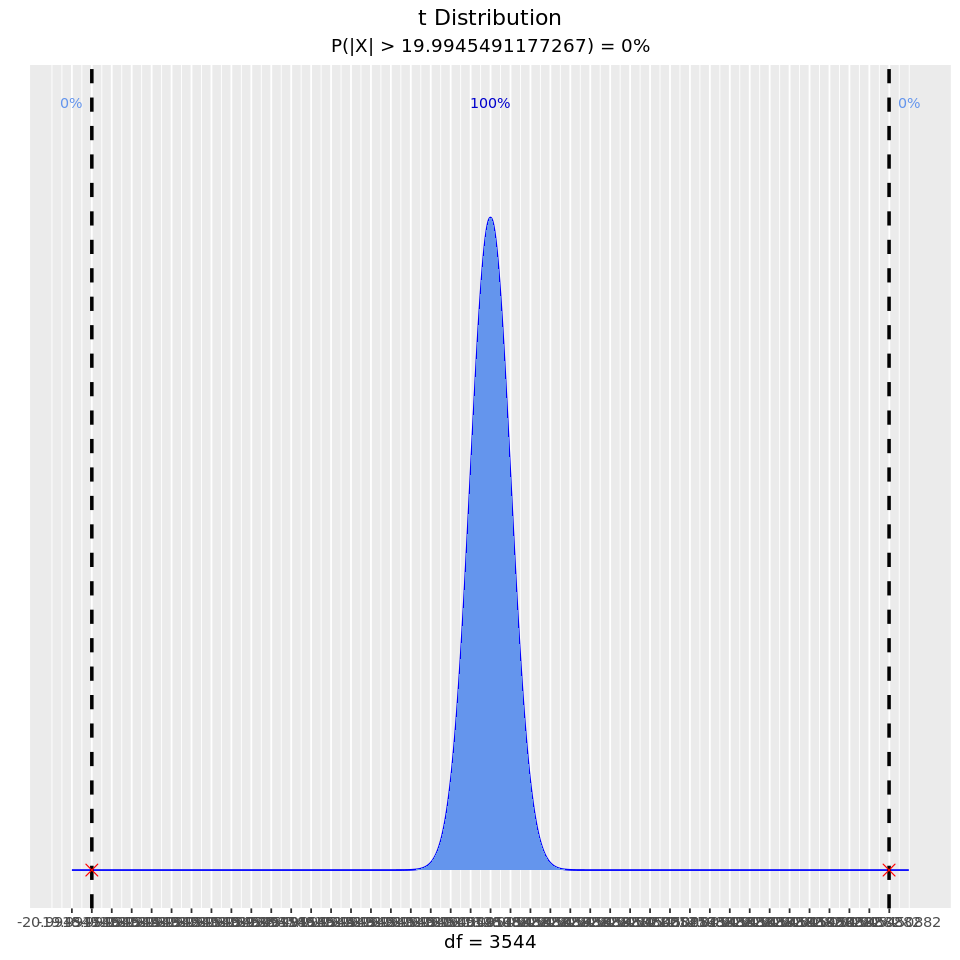

In [8]:
library(vistributions)

# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

vdist_t_prob(perc = t_b0, df = df, type="both")

- BMI

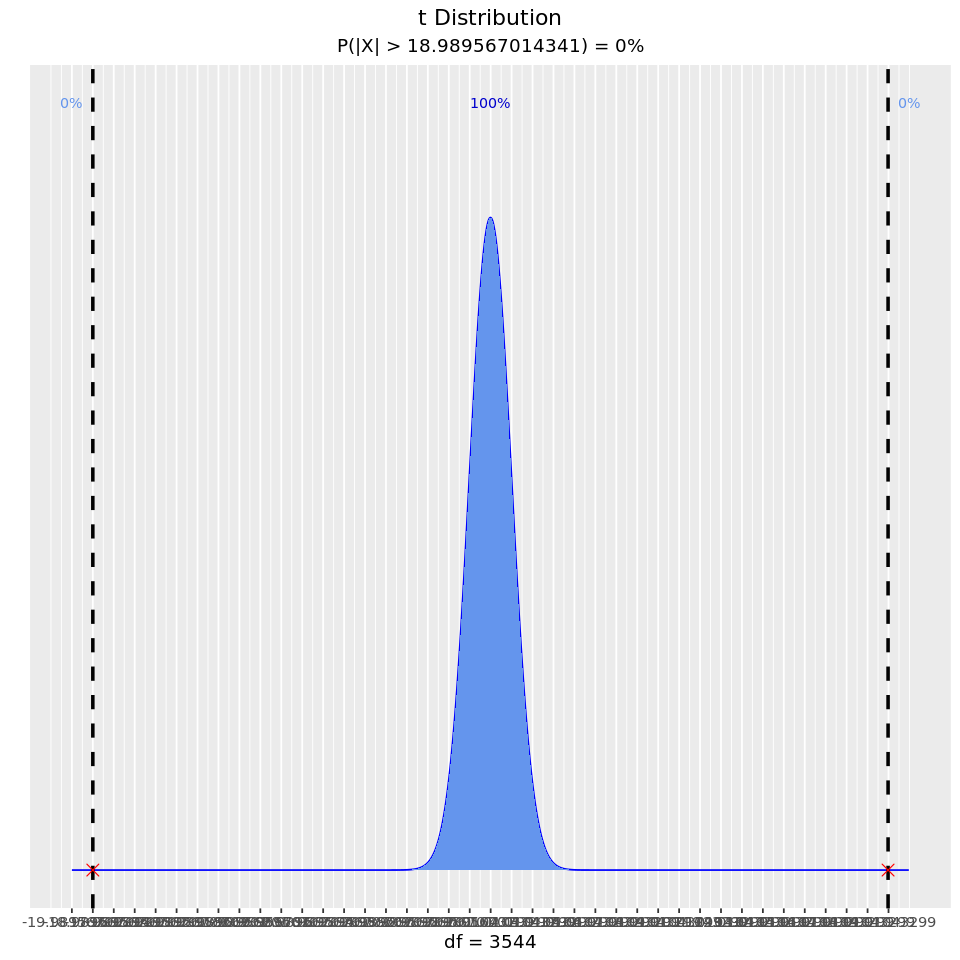

In [9]:
vdist_t_prob(perc = t_b1, df = df, type="both")

- age

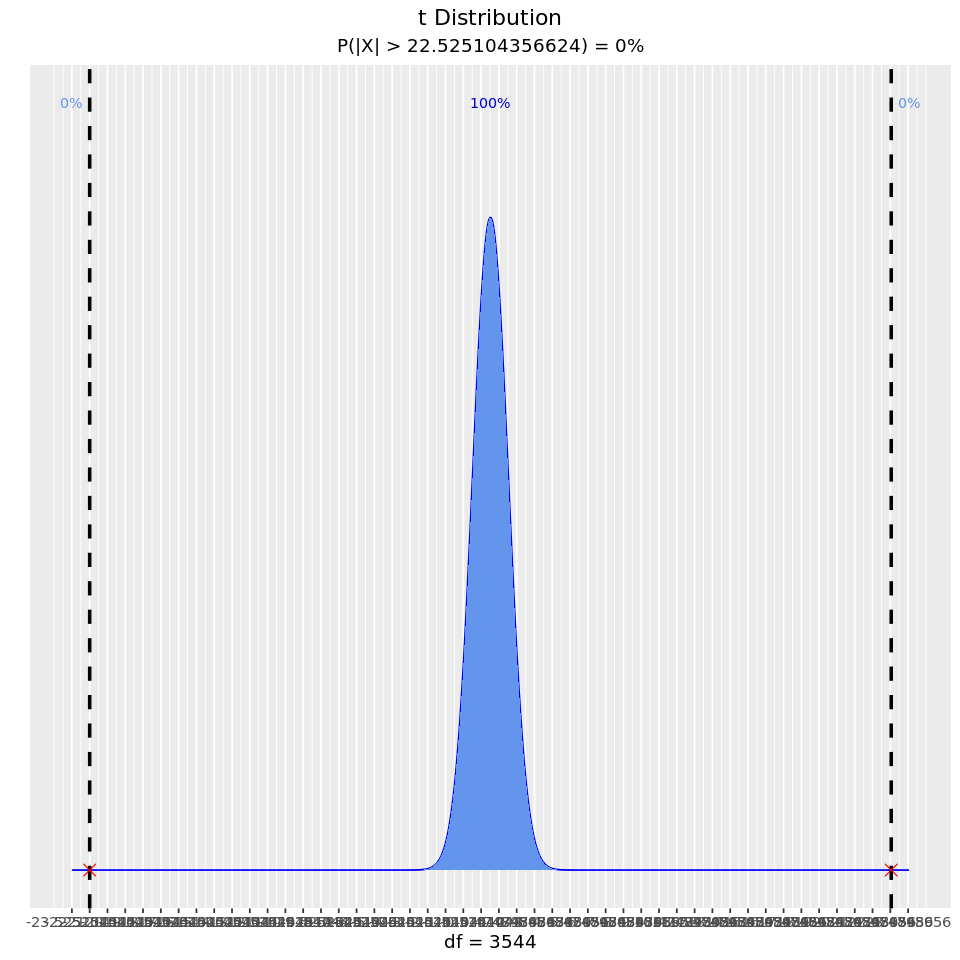

In [10]:
vdist_t_prob(perc = t_b2, df = df, type="both")

### Confidence interval of coefficients

Recall that the 95% confidence interval is defined as

$$\bar{x}-t_\mathit{lower}\times{SE} \leq \mu \leq \bar{x}+t_\mathit{upper}\times{SE}$$

$$
\begin{align}
\text{where } \mu &= \text{population mean of coefficient}\\
\bar{x} &= \text{sample mean of coefficient}\\
SE &= \text{standard error } \frac{s}{\sqrt{n}}\\
t_\mathit{lower} &= 2.5 \text{ percentile t-score}\\
t_\mathit{upper} &= 97.5 \text{ percentile t-score}
\end{align}
$$

The lower and upper t-scores are obtained using the `qt` function

In [11]:
lower_t_score <- qt(0.025, df = df)
upper_t_score <- qt(0.975, df = df)

tibble(percentile=c("0.025","0.975"),
       t_score=c(lower_t_score,upper_t_score))

percentile,t_score
<chr>,<dbl>
0.025,-1.960634
0.975,1.960634


We obtain the coefficient values and their standard errors from the `lm` object

In [12]:
b0 <- fit$coefficients[1,1] # intercept
b1 <- fit$coefficients[2,1] # BMI
b2 <- fit$coefficients[3,1] # age

se_b0 <- fit$coefficients[1,2] # intercept
se_b1 <- fit$coefficients[2,2] # BMI
se_b2 <- fit$coefficients[3,2] # age

tibble(type=c("intercept","BMI","age"),
       coefficient=c(b0,b1,b2),
       std_err=c(se_b0,se_b1,se_b2))

type,coefficient,std_err
<chr>,<dbl>,<dbl>
intercept,51.5287670,2.57714073
BMI,1.4990839,0.07894250
age,0.8358078,0.03710561


**intercept**
- `lower`: intercept + t_score(0.025) x std error of intercept
- `upper`: intercept + t_score(0.975) x std error of intercept

In [13]:
# 95% CI for b0

b0 + lower_t_score * se_b0
b0 + upper_t_score * se_b0

[1] 46.47594

[1] 56.5816

**BMI**
- `lower`: BMI + t_score(0.025) x std error of BMI
- `upper`: BMI + t_score(0.975) x std error of BMI

In [14]:
# 95% CI for b1

b1 + lower_t_score * se_b1
b1 + upper_t_score * se_b1

[1] 1.344307

[1] 1.653861

**age**
- `lower`: age + t_score(0.025) x std error of age
- `upper`: age + t_score(0.975) x std error of age

In [15]:
# 95% CI for b2

b2 + lower_t_score * se_b2
b2 + upper_t_score * se_b2

[1] 0.7630573

[1] 0.9085583

## Using library functions

We use the `lm` function to obtain the estimates and the _p-values_

In [16]:
fit_BMI_age <- lm(sysBP ~ BMI + age, data)

broom::tidy(fit_BMI_age)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),51.5287670,2.57714073,19.99455,2.335230e-84
BMI,1.4990839,0.07894250,18.98957,1.179596e-76
age,0.8358078,0.03710561,22.52510,4.052878e-105


To get the confidence intervals of the coefficients, we use the `confint` function on the `lm` object

In [17]:
confint(fit_BMI_age)

,2.5 %,97.5 %
(Intercept),46.4759383,56.5815957
BMI,1.3443066,1.6538612
age,0.7630573,0.9085583


---
## How well does the model fit the data?

We can assess how well the model fits the data by looking at
- goodness of fit measures:  $R^2$ and adjusted $R^2$
- diagnostic plots of the residuals after fitting

### 1. $R^2$ and adjusted $R^2$

We can estimate the goodness of fit of the model to the data by looking at the $R^2$ and adjusted $R^2$

In [18]:
summary(fit_BMI_age)$r.squared
summary(fit_BMI_age)$adj.r.squared

[1] 0.2183839

[1] 0.2179428

We can see that the $R^2$ has increased compared to the single covariate fit (BMI only), indicating that the additional covariate (age) improved the fit to the data

In [19]:
summary(fit_BMI)$r.squared
summary(fit_BMI)$adj.r.squared

[1] 0.1064831

[1] 0.106231

### 2. Diagnostic plot of residuals

We can look at the plot of residuals

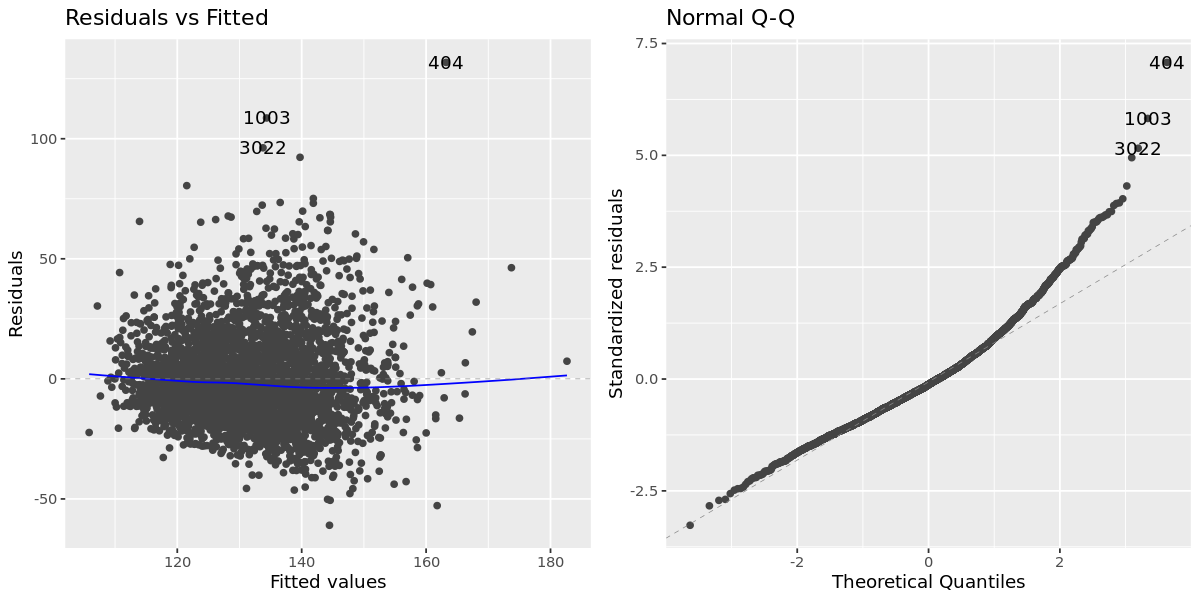

In [20]:
library(ggfortify)

# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=5)

autoplot(fit_BMI_age, which = 1:2)

Most residuals are centered around 0 and the QQ plot shows that that the residuals are closer to a normal distribution except for the higher values and outliers

We can compare this to the previous fit with only BMI as the covariate

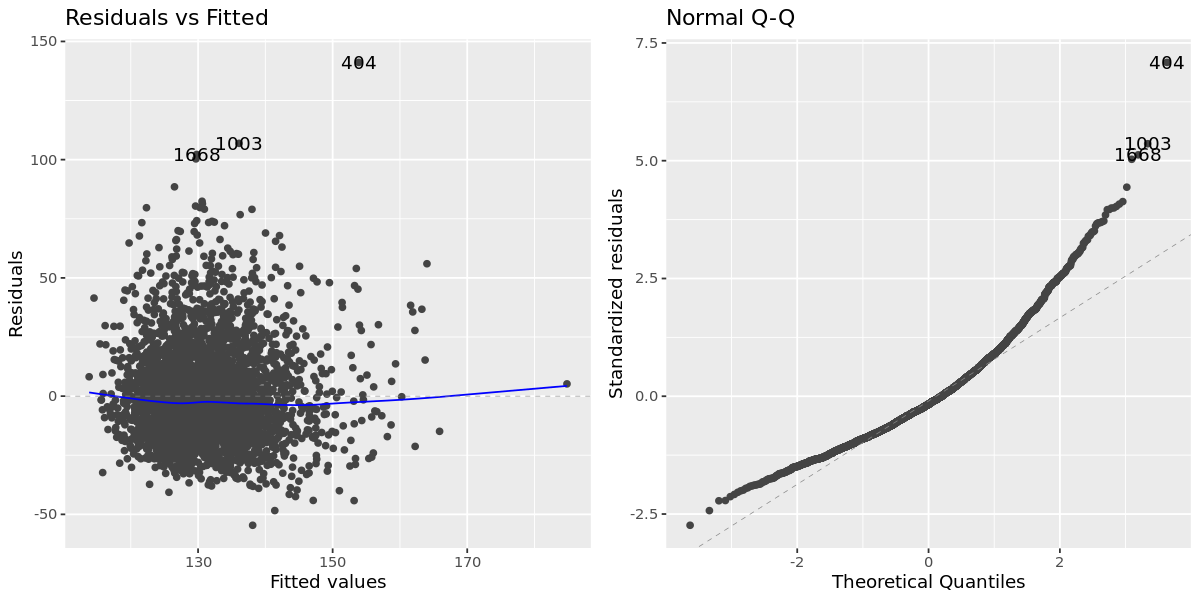

In [21]:
# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=5)

autoplot(fit_BMI, which = 1:2)

---
## The problem of highly correlated variables

For a linear model with multiple covariates, we use the matrix form

$$Y=X \beta+e$$


Recall that we obtain the beta coefficients via the following matrix operation that finds the minimum $SS$

$$\hat{\beta}=\left(X^{T} X\right)^{-1} X^{T} Y$$

If covariates are highly correlated, the $X^{T} X$ matrix cannot be inverted thus leading to spurious results

We'll illustrate by adding another covariate called `BMI_related` which is derived from `BMI`

In [22]:
# create a highly correlated covariate 

data_correlated <- data %>% mutate(BMI_related = jitter(BMI,amount = 3))

head(data_correlated)

sex,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,BMI_related
<fct>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,39,4,0,0,0,0,0,0,195,106.0,70,26.97,80,77,0,27.80752
0,46,2,0,0,0,0,0,0,250,121.0,81,28.73,95,76,0,31.47690
1,48,1,1,20,0,0,0,0,245,127.5,80,25.34,75,70,0,25.96449
0,61,3,1,30,0,0,1,0,225,150.0,95,28.58,65,103,1,30.12650
0,46,3,1,23,0,0,0,0,285,130.0,84,23.10,85,85,0,22.87882
0,43,2,0,0,0,0,1,0,228,180.0,110,30.30,77,99,0,28.18421


We can plot the pairs of variables to look a the correlations using `ggpairs`

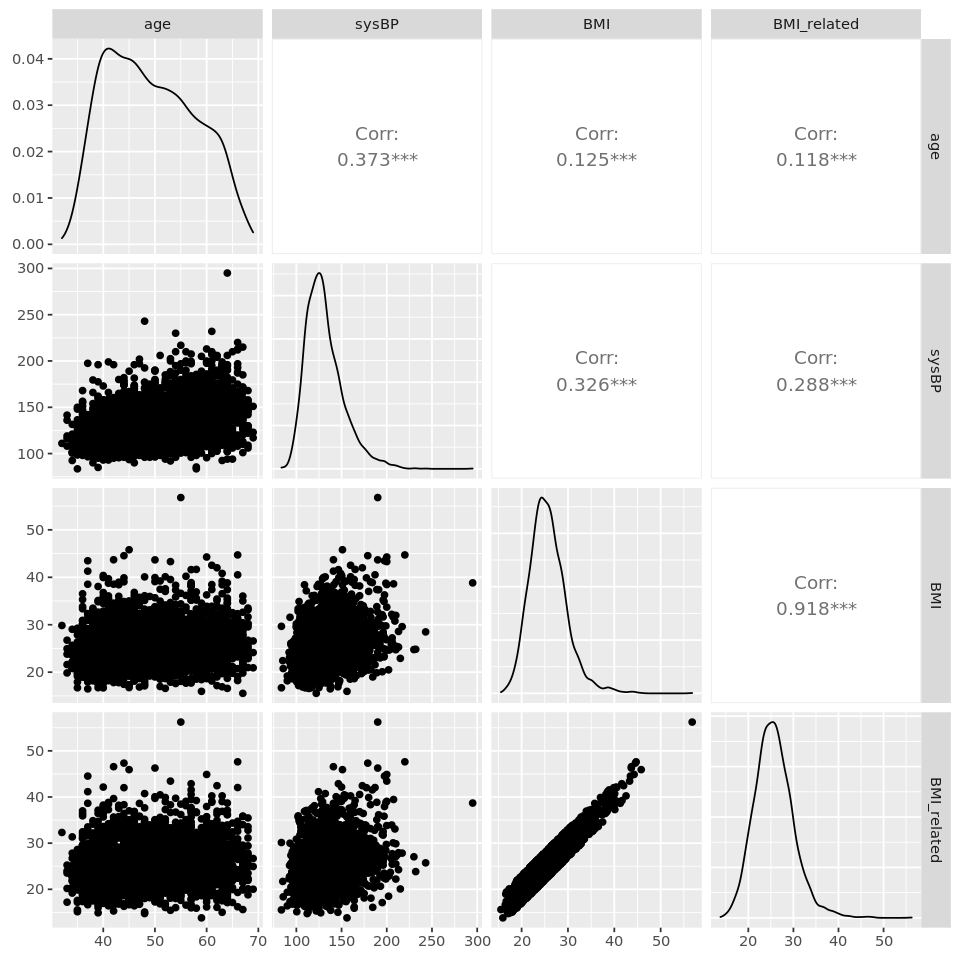

In [23]:
library(GGally)

# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

data_correlated %>% select(age, sysBP, BMI , BMI_related) %>% 
                    ggpairs

Let us fit different combinations of covariates and inspect the models
- `BMI + age`

In [24]:
# BMI + age covariates

fit_BMI_age <- lm(sysBP ~ BMI + age, data_correlated)

broom::tidy(fit_BMI_age)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),51.5287670,2.57714073,19.99455,2.335230e-84
BMI,1.4990839,0.07894250,18.98957,1.179596e-76
age,0.8358078,0.03710561,22.52510,4.052878e-105


- `BMI_related + age`

In [25]:
# BMI_related + age covariates

fit_BMI_related_age <- lm(sysBP ~ BMI_related + age, data_correlated)

broom::tidy(fit_BMI_related_age)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),58.6600898,2.49530557,23.50818,1.104611e-113
BMI_related,1.1907482,0.07288212,16.33800,6.588480e-58
age,0.8513382,0.03752784,22.68551,1.693459e-106


- `BMI + BMI_related + age`

In [26]:
# BMI + BMI_related +age covariates

fit_BMI_mixed_age <- lm(sysBP ~ BMI + BMI_related + age, data_correlated)

broom::tidy(fit_BMI_mixed_age)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),51.4455100,2.57601123,19.970996,3.578417e-84
BMI,1.8997867,0.19798375,9.595670,1.520430e-21
BMI_related,-0.3984864,0.18057878,-2.206718,2.739768e-02
age,0.8365344,0.03708683,22.556102,2.206603e-105


We notice something strange here. Although both BMI and BMI_related should be both significant in the model, only one of the covariates is significant
- Both BMI and BMI_related are highly correlated and this collinearity can affect the estimates of the linear model 

### Using a variance inflation factor (VIF) to detect collinearity

How can we detect collinearity for highly correlated covariates? We can check how much each covariate contributes to the increase in variance when the covariate is regressed to the other covariates
- We find $R^2$ when covariate $j$ is regressed to the other covariates: `lm(covariate_j ~ other covariate(s))`
- We calculate the VIF for covariate $j$

$$\mathit{VIF}_{j}=\frac{1}{1-R_{j}^{2}}$$




VIF for `age`

In [27]:
# age regressed to other covariates

r2_age <- summary(lm(age ~ BMI + BMI_related, data_correlated))$r.squared

# VIF age

1/(1-r2_age)

[1] 1.015907

VIF for `BMI`

In [28]:
# BMI regressed to other covariates

r2_BMI <- summary(lm(BMI ~ age + BMI_related, data_correlated))$r.squared

# VIF BMI

1/(1-r2_BMI)

[1] 6.396334

VIF for `BMI_related`

In [29]:
# BMI_related regressed to other covariates

r2_BMI_related <- summary(lm(BMI_related ~ age + BMI, data_correlated))$r.squared

# VIF B

1/(1-r2_BMI_related)

[1] 6.385769

We see that when BMI or BMI_related are regressed to the remaining covariates, the VIF is high (>5). This indicates that these covariates are likely to be correlated

**Using library functions**

We can use the `vif` function from the `car` library to calculate the VIFs for covariates in a model

In [30]:
car::vif(fit_BMI_mixed_age)

BMI BMI_related         age 
   6.396334    6.385769    1.015907

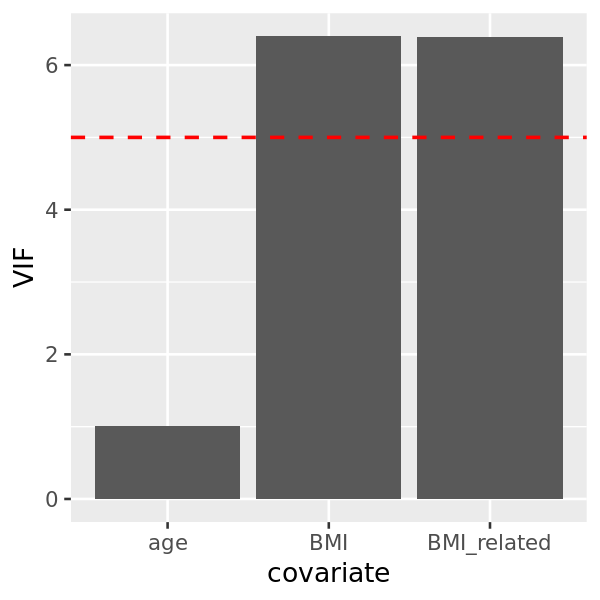

In [31]:
# adjust size of the image output

options(repr.plot.width=5, repr.plot.height=5)

# transform to table for plotting

fit_vif <- car::vif(fit_BMI_mixed_age) %>% 
           bind_rows %>%
           pivot_longer(cols = everything(), 
                        names_to="covariate", 
                        values_to = "VIF")

# plot VIF

fit_vif %>% ggplot(aes(x=covariate, y=VIF)) + 
              geom_bar(stat="identity") +
              geom_hline(yintercept = 5, linetype="dashed", color="red", size=1) +
              theme_grey(base_size=16)

So what can we do about it? When covariates are highly correlated, we can
- Omit one of the correlated covariates
- Combine them into a single covariate (e.g. mean BP to combine systolic BP and diastolic BP)

---
# Application: Statistical table and plotting

We will be using these libraries for making statistical tables  and plots for the linear models
- `stargazer`: statistical tables for models
- `ggstatsplot`: plotting of the model coefficients
- `ggfortify`: diagnostic plots for models

To illustrate how we use them, we will build several models looking at the relationship between `sysBP` and `BMI` and`age` variables in the Framingham dataset

In [ ]:
library(tidyverse)

# load data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# filter out cases with BPMeds and drop missing values
data <- data %>%
        filter(BPMeds==0) %>%
        drop_na  

head(data)

## 1. Statistical table

We will use the `stargazer` function from the `stargazer` library to generate a statistical table from the model. The function can take one or more models as its input and we can specify the following options
- `ci`: set to TRUE to print the confidence intervals
- `type`: set to HTML to print the table in the notebook

We will define a local function `print_html` to print the HTML output from `stargazer` in the notebook

In [ ]:
# print table convenience function

print_html <- function(input) {
    
    capture.output(input) %>% 
    paste(collapse="") %>%
    IRdisplay::display_html()
    
}

We will fit several models and print them in a table

In [ ]:
fit_BMI <- lm(sysBP ~ BMI, data)
fit_age <- lm(sysBP ~ age, data)
fit_BMI_age <- lm(sysBP ~ BMI + age, data)

# print stargazer table and compare all 3 models

library(stargazer)

stargazer(fit_BMI, fit_age, fit_BMI_age, ci=TRUE, type="html") %>% print_html

## 2. Statistical plot

We will use the `ggcoefstats` function from `ggstatsplot` to generate a plot of the coefficients with the confidence intervals and the associate p-values. We can specify the following options
- `exclude.intercept`: set to TRUE to omit the intercept
- `stats.label.args`: provide a list of options for the labels if desired

In [ ]:
library(ggstatsplot)

# adjust size of the image output
options(repr.plot.width=8, repr.plot.height=8)

fit_BMI_age %>% ggcoefstats(exclude.intercept = T,
                            stats.label.args=list(nudge_y=0.2, 
                                                  size=5, 
                                                  label.size=NA)) +
                theme_grey(base_size=16)

## 3. Diagnostic plot

We will use the `autoplot` function from the `ggfortify` library to generate basic diagnostic plots of the residuals. For simplicity, we specify the option `which = 1:2` to limit the plots to
- Residuals vs Fitted
- Normal Q-Q

In [ ]:
library(ggfortify)

# adjust size of the image output
options(repr.plot.width=10, repr.plot.height=5)

autoplot(fit_BMI_age, which = 1:2)

---
## Exercise - Modeling (Multiple covariates)

For this exercise, we will use the Framingham dataset and model the relationship between `totChol` and 2 covariates `BMI` and `age`

In [ ]:
library(tidyverse)

# load data
data<- read_csv("https://raw.githubusercontent.com/kennethban/dataset/main/framingham.csv")

# rename and change data types
data <- data %>%
        rename(sex = male) %>%
        mutate(sex = as.factor(sex)) %>%
        mutate(education = as.factor(education)) %>%
        mutate(currentSmoker = as.factor(currentSmoker)) %>%
        mutate(BPMeds = as.factor(BPMeds)) %>%
        mutate(prevalentStroke = as.factor(prevalentStroke)) %>%
        mutate(prevalentHyp = as.factor(prevalentHyp)) %>%
        mutate(diabetes = as.factor(diabetes)) %>%
        mutate(TenYearCHD = as.factor(TenYearCHD))

# filter out cases with BPMeds and drop missing values
data <- data %>%
        filter(BPMeds==0) %>%
        drop_na  

head(data)

We will define a local function `print_html` to print the HTML output from `stargazer` in the notebook

In [ ]:
# print html convenience function

print_html <- function(input) {
    
    capture.output(input) %>% 
    paste(collapse="") %>% 
    IRdisplay::display_html()
    
}

### Part 1

Build a linear model using the `lm` function and store it as `myfit_BMI`
- `totChol`: dependent/response variable
- `BMI`: independent/explanatory variable

Build a linear model using the `lm` function and store it as `myfit_age`
- `totChol`: dependent/response variable
- `age`: independent/explanatory variable

Build a linear model using the `lm` function and store it as `myfit_BMI_age`
- `totChol`: dependent/response variable
- `BMI`: independent/explanatory variable
- `age`: independent/explanatory variable

Create a `stargazer` table that shows 3 models side-by-side
- Explain the coefficients
- Explain which model may be a better fit to the data

In [ ]:
library(stargazer)

# start here

In [ ]:
# solution

library(stargazer)

myfit_BMI <- lm(totChol ~ BMI, data)
myfit_age <- lm(totChol ~ age, data)
myfit_BMI_age <- lm(totChol ~ BMI + age, data)

stargazer(myfit_BMI, myfit_age, myfit_BMI_age, ci = T, type="html") %>% print_html

### Part 2

Use `ggcoefstats` to plot the coefficient(s) in the `myfit_BMI_age` model. You may exclude the intercept from the plot

In [ ]:
library(ggstatsplot)

# start here

In [ ]:
# solution

library(ggstatsplot)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=8)

myfit_BMI_age %>% ggcoefstats(exclude.intercept = T)

### Part 3

Create a diagnostic plot for the `myfit_bmi_age` model using `autoplot` from `ggfortify`
- Interpret the plot

In [ ]:
library(ggfortify)

# start here

In [ ]:
# solution

library(ggfortify)

# set plot dimensions
options(repr.plot.width=8, repr.plot.height=4)

myfit_BMI_age %>% autoplot(which=1:2)